In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Load the dataset (replace 'anomaly_detection.csv' with your file path)
df = pd.read_csv('anomaly_detection.csv')

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])


In [2]:
df.head()

,date,value,agency,anomaly
0,2020-01-01,197,AAA,0
1,2020-01-01,404,CCC,0
2,2020-01-01,153,BBB,0
3,2020-01-02,205,AAA,0
4,2020-01-02,401,CCC,0


In [3]:
# One-hot encode 'agency'
agency_dummies = pd.get_dummies(df['agency'], prefix='agency')
df = pd.concat([df, agency_dummies], axis=1)

df = df.astype({'agency_AAA': 'int64', 'agency_BBB': 'int64','agency_CCC': 'int64'})


In [4]:
df.head()

,date,value,agency,anomaly,agency_AAA,agency_BBB,agency_CCC
0,2020-01-01,197,AAA,0,1,0,0
1,2020-01-01,404,CCC,0,0,0,1
2,2020-01-01,153,BBB,0,0,1,0
3,2020-01-02,205,AAA,0,1,0,0
4,2020-01-02,401,CCC,0,0,0,1


In [5]:
# Extract date-based features
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['month'] = df['date'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

df.head()


,date,value,agency,anomaly,agency_AAA,agency_BBB,agency_CCC,day_of_week,month,is_weekend
0,2020-01-01,197,AAA,0,1,0,0,2,1,0
1,2020-01-01,404,CCC,0,0,0,1,2,1,0
2,2020-01-01,153,BBB,0,0,1,0,2,1,0
3,2020-01-02,205,AAA,0,1,0,0,3,1,0
4,2020-01-02,401,CCC,0,0,0,1,3,1,0


In [6]:
# Computing rolling mean per agency (grouped and sorted)
df.sort_values(['agency', 'date'], inplace=True)
df['value_rolling_mean_7'] = df.groupby('agency')['value'].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)

# Sort the entire dataset by date for time-series split
df.sort_values('date', inplace=True)


In [7]:
# Calculate deviation from rolling mean
df['value_deviation'] = df['value'] - df['value_rolling_mean_7']
df.head()

,date,value,agency,anomaly,agency_AAA,agency_BBB,agency_CCC,day_of_week,month,is_weekend,value_rolling_mean_7,value_deviation
0,2020-01-01,197,AAA,0,1,0,0,2,1,0,197.0,0.0
1,2020-01-01,404,CCC,0,0,0,1,2,1,0,404.0,0.0
2,2020-01-01,153,BBB,0,0,1,0,2,1,0,153.0,0.0
3,2020-01-02,205,AAA,0,1,0,0,3,1,0,201.0,4.0
4,2020-01-02,401,CCC,0,0,0,1,3,1,0,402.5,-1.5


In [8]:
# Split based on time (80% training, 20% testing)
train_size = int(0.8 * len(df))
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Define features and target
features = ['value','agency_AAA', 'agency_BBB', 'agency_CCC',
            'day_of_week', 'month', 'is_weekend', 'value_rolling_mean_7','value_deviation']
X_train = train_df[features]
y_train = train_df['anomaly']
X_test = test_df[features]
y_test = test_df['anomaly']

In [9]:
# Initialize and train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.8260089686098655

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       629
           1       0.82      0.77      0.79       486

    accuracy                           0.83      1115
   macro avg       0.83      0.82      0.82      1115
weighted avg       0.83      0.83      0.83      1115


Confusion Matrix:
 [[547  82]
 [112 374]]


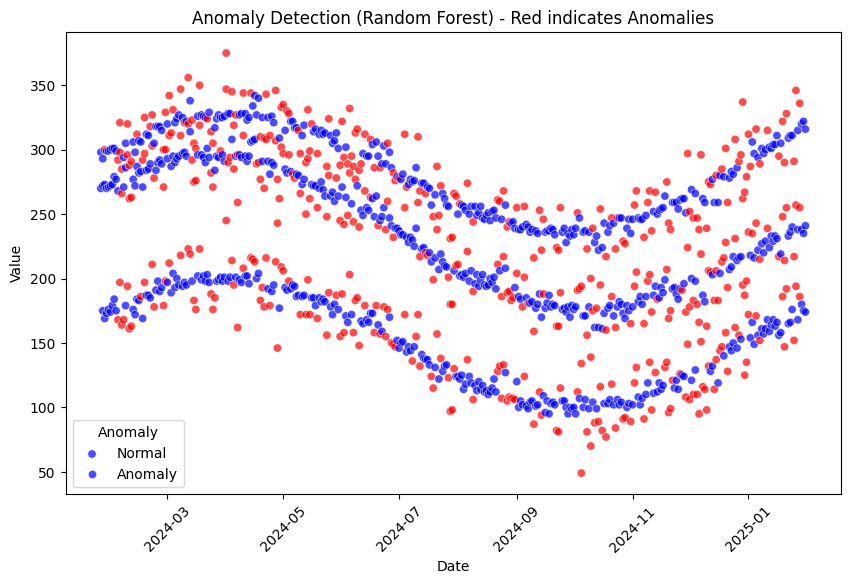

In [10]:
# Predict on test data
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = rf.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



# Scatter plot visualization for anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_df['date'], y=test_df['value'], hue=y_pred, palette={0: 'blue', 1: 'red'}, alpha=0.7)

plt.title("Anomaly Detection (Random Forest) - Red indicates Anomalies")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(title="Anomaly", labels=["Normal", "Anomaly"])
plt.xticks(rotation=45)
plt.show()

In [11]:
!pip install xgboost


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



🔹 XGBoost (Before Tuning) Accuracy: 0.8269058295964126

🔹 XGBoost (After Tuning) Accuracy: 0.8322869955156951

🔹 XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       629
           1       0.85      0.75      0.80       486

    accuracy                           0.83      1115
   macro avg       0.84      0.82      0.83      1115
weighted avg       0.83      0.83      0.83      1115


🔹 XGBoost Confusion Matrix:
 [[564  65]
 [122 364]]


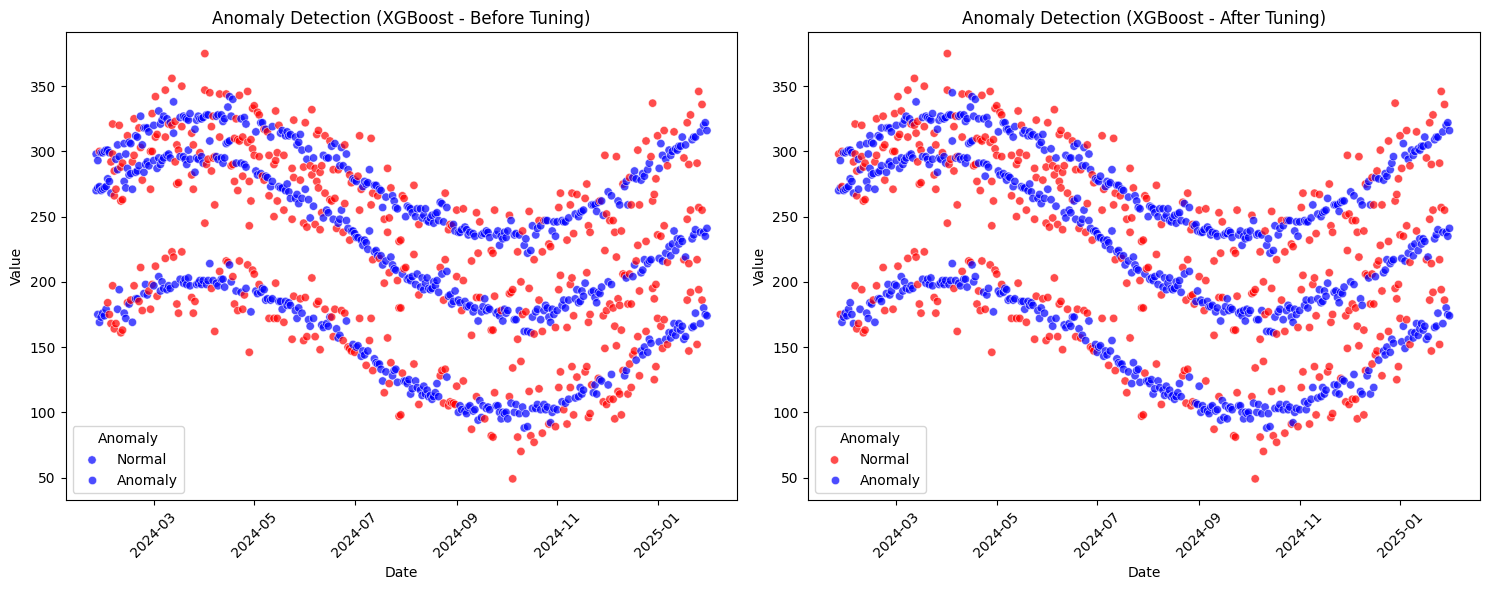

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# ------------------ XGBoost BEFORE Tuning ------------------ #

xgb_before = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_before.fit(X_train, y_train)

# Predict using default XGBoost
y_pred_xgb_before = xgb_before.predict(X_test)

print("\n🔹 XGBoost (Before Tuning) Accuracy:", accuracy_score(y_test, y_pred_xgb_before))

# ------------------ Hyperparameter Tuning for XGBoost ------------------ #

xgb = XGBClassifier(random_state=42, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1]
}

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_estimator_

# Predict using best XGBoost model
y_pred_xgb_after = best_xgb.predict(X_test)

print("\n🔹 XGBoost (After Tuning) Accuracy:", accuracy_score(y_test, y_pred_xgb_after))
print("\n🔹 XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb_after))
print("\n🔹 XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_after))

# ------------------ Scatter Plot Comparison ------------------ #

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot BEFORE tuning
sns.scatterplot(ax=axes[0], x=test_df['date'], y=test_df['value'], hue=y_pred_xgb_before, palette={0: 'blue', 1: 'red'}, alpha=0.7)
axes[0].set_title("Anomaly Detection (XGBoost - Before Tuning)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Value")
axes[0].legend(title="Anomaly", labels=["Normal", "Anomaly"])
axes[0].tick_params(axis='x', rotation=45)

# Scatter plot AFTER tuning
sns.scatterplot(ax=axes[1], x=test_df['date'], y=test_df['value'], hue=y_pred_xgb_after, palette={0: 'blue', 1: 'red'}, alpha=0.7)
axes[1].set_title("Anomaly Detection (XGBoost - After Tuning)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Value")
axes[1].legend(title="Anomaly", labels=["Normal", "Anomaly"])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

from sklearn.svm import SVC

# ------------------ SVM BEFORE Tuning ------------------ #

svm_before = SVC(kernel='rbf', random_state=42)
svm_before.fit(X_train, y_train)

# Predict using default SVM
y_pred_svm_before = svm_before.predict(X_test)

print("\n🔹 SVM (Before Tuning) Accuracy:", accuracy_score(y_test, y_pred_svm_before))

# ------------------ Hyperparameter Tuning for SVM ------------------ #

svm = SVC(random_state=42)

param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

best_svm = grid_search_svm.best_estimator_

# Predict using best SVM model
y_pred_svm_after = best_svm.predict(X_test)

print("\n🔹 SVM (After Tuning) Accuracy:", accuracy_score(y_test, y_pred_svm_after))
print("\n🔹 SVM Classification Report:\n", classification_report(y_test, y_pred_svm_after))
print("\n🔹 SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm_after))

# ------------------ Scatter Plot Comparison ------------------ #

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot BEFORE tuning
sns.scatterplot(ax=axes[0], x=test_df['date'], y=test_df['value'], hue=y_pred_svm_before, palette={0: 'blue', 1: 'red'}, alpha=0.7)
axes[0].set_title("Anomaly Detection (SVM - Before Tuning)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Value")
axes[0].legend(title="Anomaly", labels=["Normal", "Anomaly"])
axes[0].tick_params(axis='x', rotation=45)

# Scatter plot AFTER tuning
sns.scatterplot(ax=axes[1], x=test_df['date'], y=test_df['value'], hue=y_pred_svm_after, palette={0: 'blue', 1: 'red'}, alpha=0.7)
axes[1].set_title("Anomaly Detection (SVM - After Tuning)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Value")
axes[1].legend(title="Anomaly", labels=["Normal", "Anomaly"])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [14]:
!pip install optuna


   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.1 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.1 MB 883.1 kB/s eta 0:00:02
   -------------- ------------------------- 0.8/2.1 MB 978.1 kB/s eta 0:00:02
   ------------------------ --------------- 1.3/2.1 MB 1.2 MB/s eta 0:00:01
   ----------------------------- ---------- 1.6/2.1 MB 1.3 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 1.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import optuna

def objective(trial):
    xgb = XGBClassifier(
        n_estimators=trial.suggest_int('n_estimators', 100, 500),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2),
        subsample=trial.suggest_float('subsample', 0.7, 1.0),
        random_state=42,
        eval_metric='logloss'
    )
    xgb.fit(X_train, y_train)
    return accuracy_score(y_test, xgb.predict(X_test))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
best_params = study.best_params
print("Best Params:", best_params)


[I 2025-03-24 12:37:06,863] A new study created in memory with name: no-name-7398ee31-d1b2-4d2d-97b0-80b32e6f3f71
[I 2025-03-24 12:37:09,307] Trial 0 finished with value: 0.8143497757847533 and parameters: {'n_estimators': 384, 'max_depth': 6, 'learning_rate': 0.12856493475557948, 'subsample': 0.7705229490948755}. Best is trial 0 with value: 0.8143497757847533.
[I 2025-03-24 12:37:11,345] Trial 1 finished with value: 0.8152466367713005 and parameters: {'n_estimators': 217, 'max_depth': 9, 'learning_rate': 0.1551010309263166, 'subsample': 0.7200255941717776}. Best is trial 1 with value: 0.8152466367713005.
[I 2025-03-24 12:37:12,904] Trial 2 finished with value: 0.8331838565022421 and parameters: {'n_estimators': 465, 'max_depth': 3, 'learning_rate': 0.04241950263861575, 'subsample': 0.9031716406453645}. Best is trial 2 with value: 0.8331838565022421.
[I 2025-03-24 12:37:14,943] Trial 3 finished with value: 0.8331838565022421 and parameters: {'n_estimators': 326, 'max_depth': 6, 'learni

Best Params: {'n_estimators': 159, 'max_depth': 4, 'learning_rate': 0.053701477779749096, 'subsample': 0.9038423241038575}
